# Idealized tropical cyclone
This is the simplified tropical cyclone test of Reed and Jablownowski, using their simple surface flux and PBL scheme with the GFDL microphysics. This test uses an aquaplanet with a uniform 30C SST, allowing pretty rapid intensification even at minimal resolutions. For our test, since the TC is the only thing going on in the entire global domain, we use the grid stretching to reach 25-km resolution in a C128 grid over the TC. We also use the new do_cube_transform option so that the stretched tile (tile6) is oriented with North at the top, as we expect. We show four simulations:

1) The control or "essentially-inviscid" case, using hord = 5, eighth-order divergence damping, and positive-definite tracer advection. This is like what we were using in nonhydrostatic HiRAM and what we are using in SHiELD and S-SHiELD
2) "4th-order damping", which uses strictly-monotonic advection for all quantities and fourth-order divergence damping. This is like what is used in hydrostatic HiRAM and in AM4.
3) "Minimally-viscous" diffusion, which is like (1) except hord = 6. Note that while this doesn't give great results at 25-km resolution it is very useful at controlling the behavior of convective systems at 3-km resolution while maintaining strong storms, and is used in T-SHiELD and HAFS. (**Moral**: What works at 3-km resolution need not work at 25-km or coarser resolutions.)
4) Monotonic tracer advection, which is like (1) except with strictly-monotonic advection applied to passive tracers. This is like what is used in the operational GFS v16 and GEFS.

While this test is crude ( it does demonstrate some nice characteristics of the dynamics on tropical cyclone vortices; most noticably it reproduces the results of Gao et al (JAS, 2021), behavior seen in SHiELD and the GFS regarding advection types, and the results from HiRAM regarding divergence damping and intense vortices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt #xarray isn't much help for these native grid plots
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
import colorsys
import xarray as xa

In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

Here we load just tile6. It is easy to plot on the native grid, although the axes should be taken as grid cells and not physical units.

In [3]:
root="/archive/Lucas.Harris/SHiELD/202103/C128r3.solo.TC%s/history/0000000000/atmos_4xdaily.tile6.nc"
ds_ctl=xa.open_dataset(root%(''),decode_times=False,chunks={'time': 1})
ds_d1 =xa.open_dataset(root%('.d1'),decode_times=False,chunks={'time': 1})
ds_h6 =xa.open_dataset(root%('.h6'),decode_times=False,chunks={'time': 1})
ds_tr8=xa.open_dataset(root%('.tr8'),decode_times=False,chunks={'time': 1})


In [4]:
ds_ctl

<xarray.Dataset>
Dimensions:       (grid_xt: 128, grid_yt: 128, time: 40)
Coordinates:
  * grid_xt       (grid_xt) float32 1.0 2.0 3.0 4.0 ... 125.0 126.0 127.0 128.0
  * grid_yt       (grid_yt) float32 1.0 2.0 3.0 4.0 ... 125.0 126.0 127.0 128.0
  * time          (time) float32 0.25 0.5 0.75 1.0 1.25 ... 9.25 9.5 9.75 10.0
Data variables: (12/14)
    vort850       (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    u850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    us            (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    vs            (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    tb            (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    ...            ...
    iw            (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    PRESsfc       (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    PRESctp       (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    TMP500_300    (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    condensation  (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    evaporation   (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          C128r3.64bit
    grid_type:      regular
    grid_tile:      N/A

Here is the minimum pressure of the TC. The control case, using "virtually-invisid" dynamics (un-limited hord = 5, eighth-order divergence damping, positive-definite tracer advection) gets quite deep, down to 925 mb at one point before weakening a bit, and on the second day undergoes rapid intensification. The control is much stronger than the other cases, which have additional diffusion in some form. Note that the intensification is unsteady in all of the cases.

Text(0.5, 1.0, 'Minimum central pressure [Pa]')

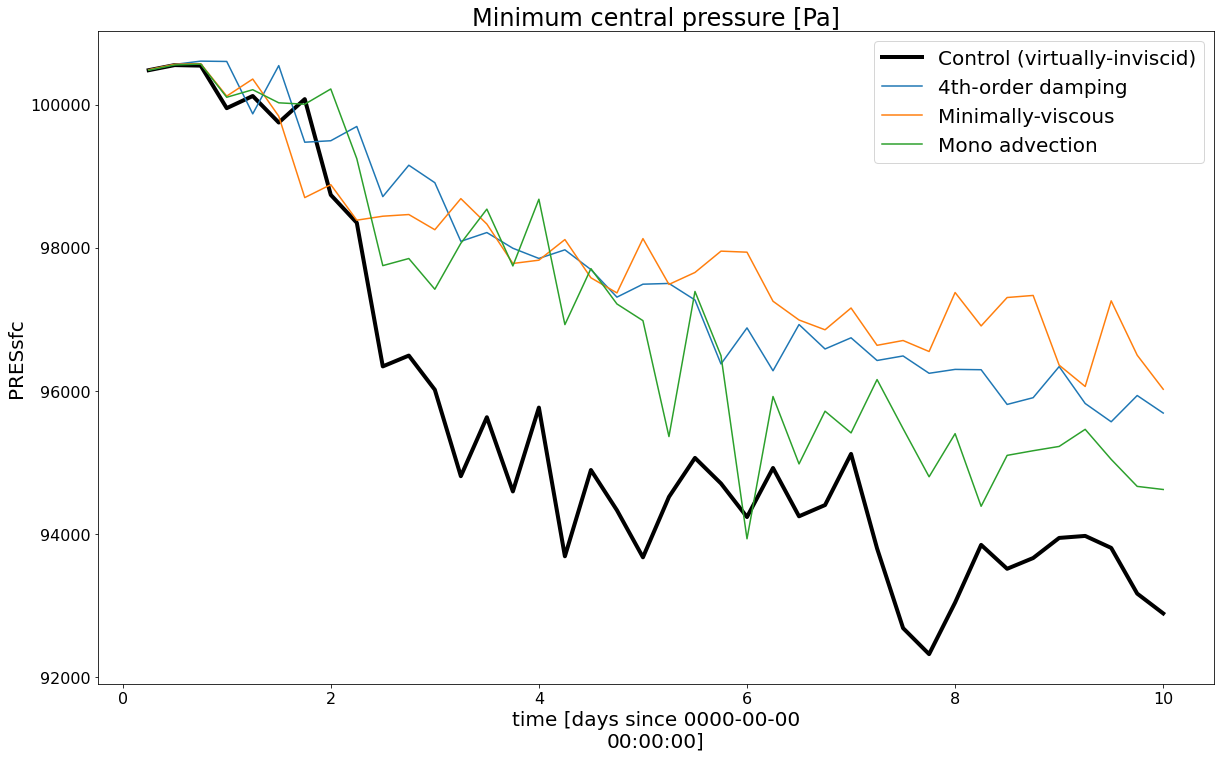

In [26]:
fig = plt.figure(figsize=(20,12))
ax = plt.subplot()
ds_ctl.PRESsfc.min(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Control (virtually-inviscid)",linewidth=4,color='k')
ds_d1.PRESsfc.min(dim=("grid_xt","grid_yt")).plot(ax=ax,label="4th-order damping")
ds_h6.PRESsfc.min(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Minimally-viscous") #Needs fixing
ds_tr8.PRESsfc.min(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Mono advection")
ax.legend()
ax.set_title("Minimum central pressure [Pa]");

We can examine 850 mb "flight-level" winds. The control case gets up to above 72 m/s and oscillates thereafter, weakening a bit in the last couple of days.

In [6]:
#create 850 mb winds
U850_ctl = np.sqrt(ds_ctl.u850**2 + ds_ctl.v850**2)
U850_d1 = np.sqrt(ds_d1.u850**2 + ds_d1.v850**2)
U850_h6 = np.sqrt(ds_h6.u850**2 + ds_h6.v850**2)
U850_tr8 = np.sqrt(ds_tr8.u850**2 + ds_tr8.v850**2)
#U850_ctl.max(dim=("grid_xt","grid_yt")).plot()

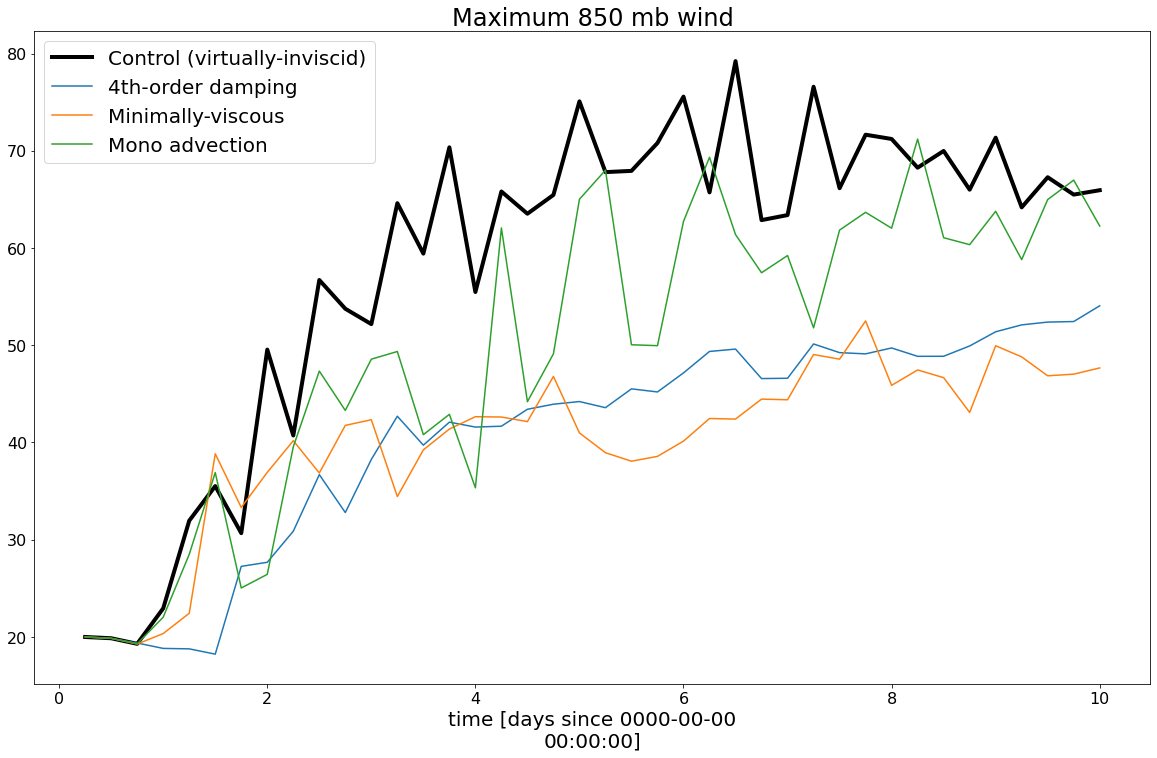

In [27]:
fig = plt.figure(figsize=(20,12))
ax = plt.subplot()
U850_ctl.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Control (virtually-inviscid)",linewidth=4,color='k')
U850_d1.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="4th-order damping")
U850_h6.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Minimally-viscous") #Needs fixing
U850_tr8.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Mono advection")
ax.legend()
ax.set_title("Maximum 850 mb wind");

As we expect, the lowest-layer winds (not really a surrogate for 10-m standard winds since the PBL scheme is pretty primitive here) are weaker but the control stil gets up to be a nice Category 2 storm. Even the more diffusive cases manage to reach tropical storm strength.

In [8]:
#create lowest-layer winds
Us_ctl = np.sqrt(ds_ctl.us**2 + ds_ctl.vs**2)
Us_d1 = np.sqrt(ds_d1.us**2 + ds_d1.vs**2)
Us_h6 = np.sqrt(ds_h6.us**2 + ds_h6.vs**2)
Us_tr8 = np.sqrt(ds_tr8.us**2 + ds_tr8.vs**2)
#Us_ctl.max(dim=("grid_xt","grid_yt")).plot()

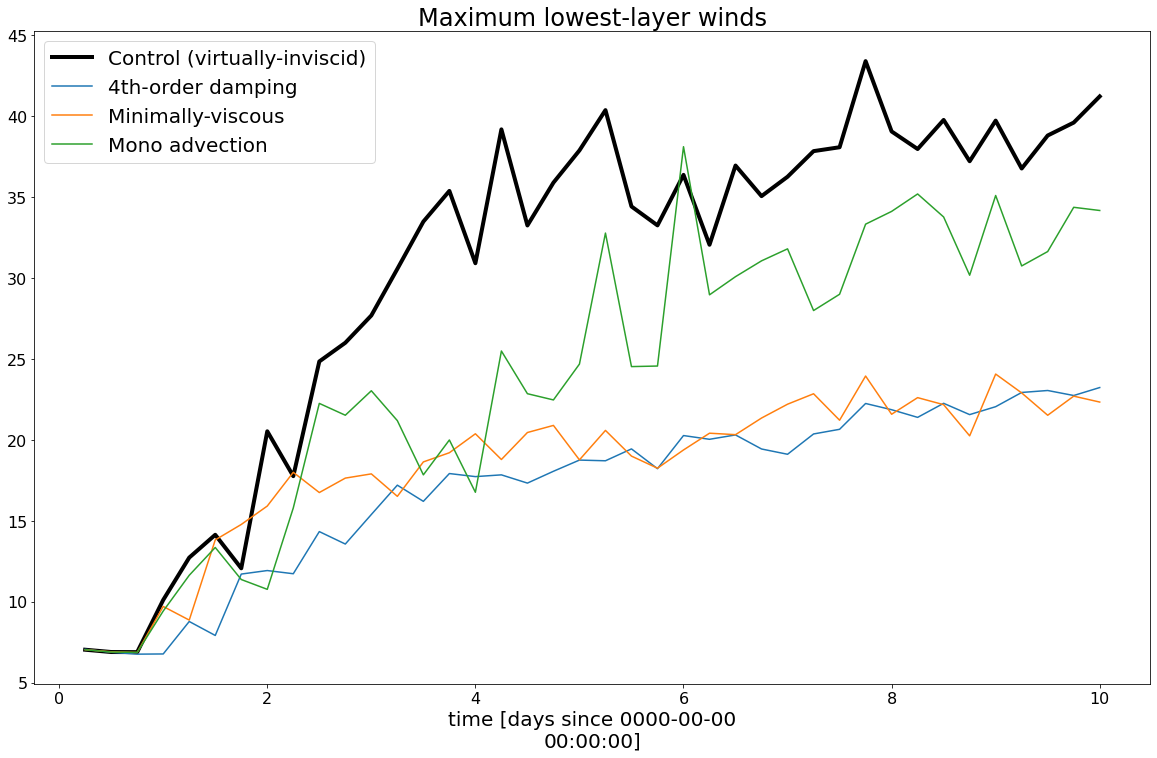

In [29]:
fig = plt.figure(figsize=(20,12))
ax = plt.subplot()
Us_ctl.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Control (virtually-inviscid)",linewidth=4,color='k')
Us_d1.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="4th-order damping")
Us_h6.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Minimally-viscous") #Needs fixing
Us_tr8.max(dim=("grid_xt","grid_yt")).plot(ax=ax,label="Mono advection")
ax.legend()
ax.set_title("Maximum lowest-layer winds");

Here's a nice plot of 850 mb winds from the control to show the formation, intensification, and pulsating of the vortex. Note between days 4 and 7 the vortex shows an asymmetric structure, as the storm's intensity levels off. This is an indication that there are interesting vortex dynamics going on even for this marginally-resolved storm, and could be a sign that the dynamical core "wants" to undergo an eyewall-replacement cycle (which it can't fully do because it doesn't have the resolution). After day 7 the storm axisymmetrizes and deepens a little more.

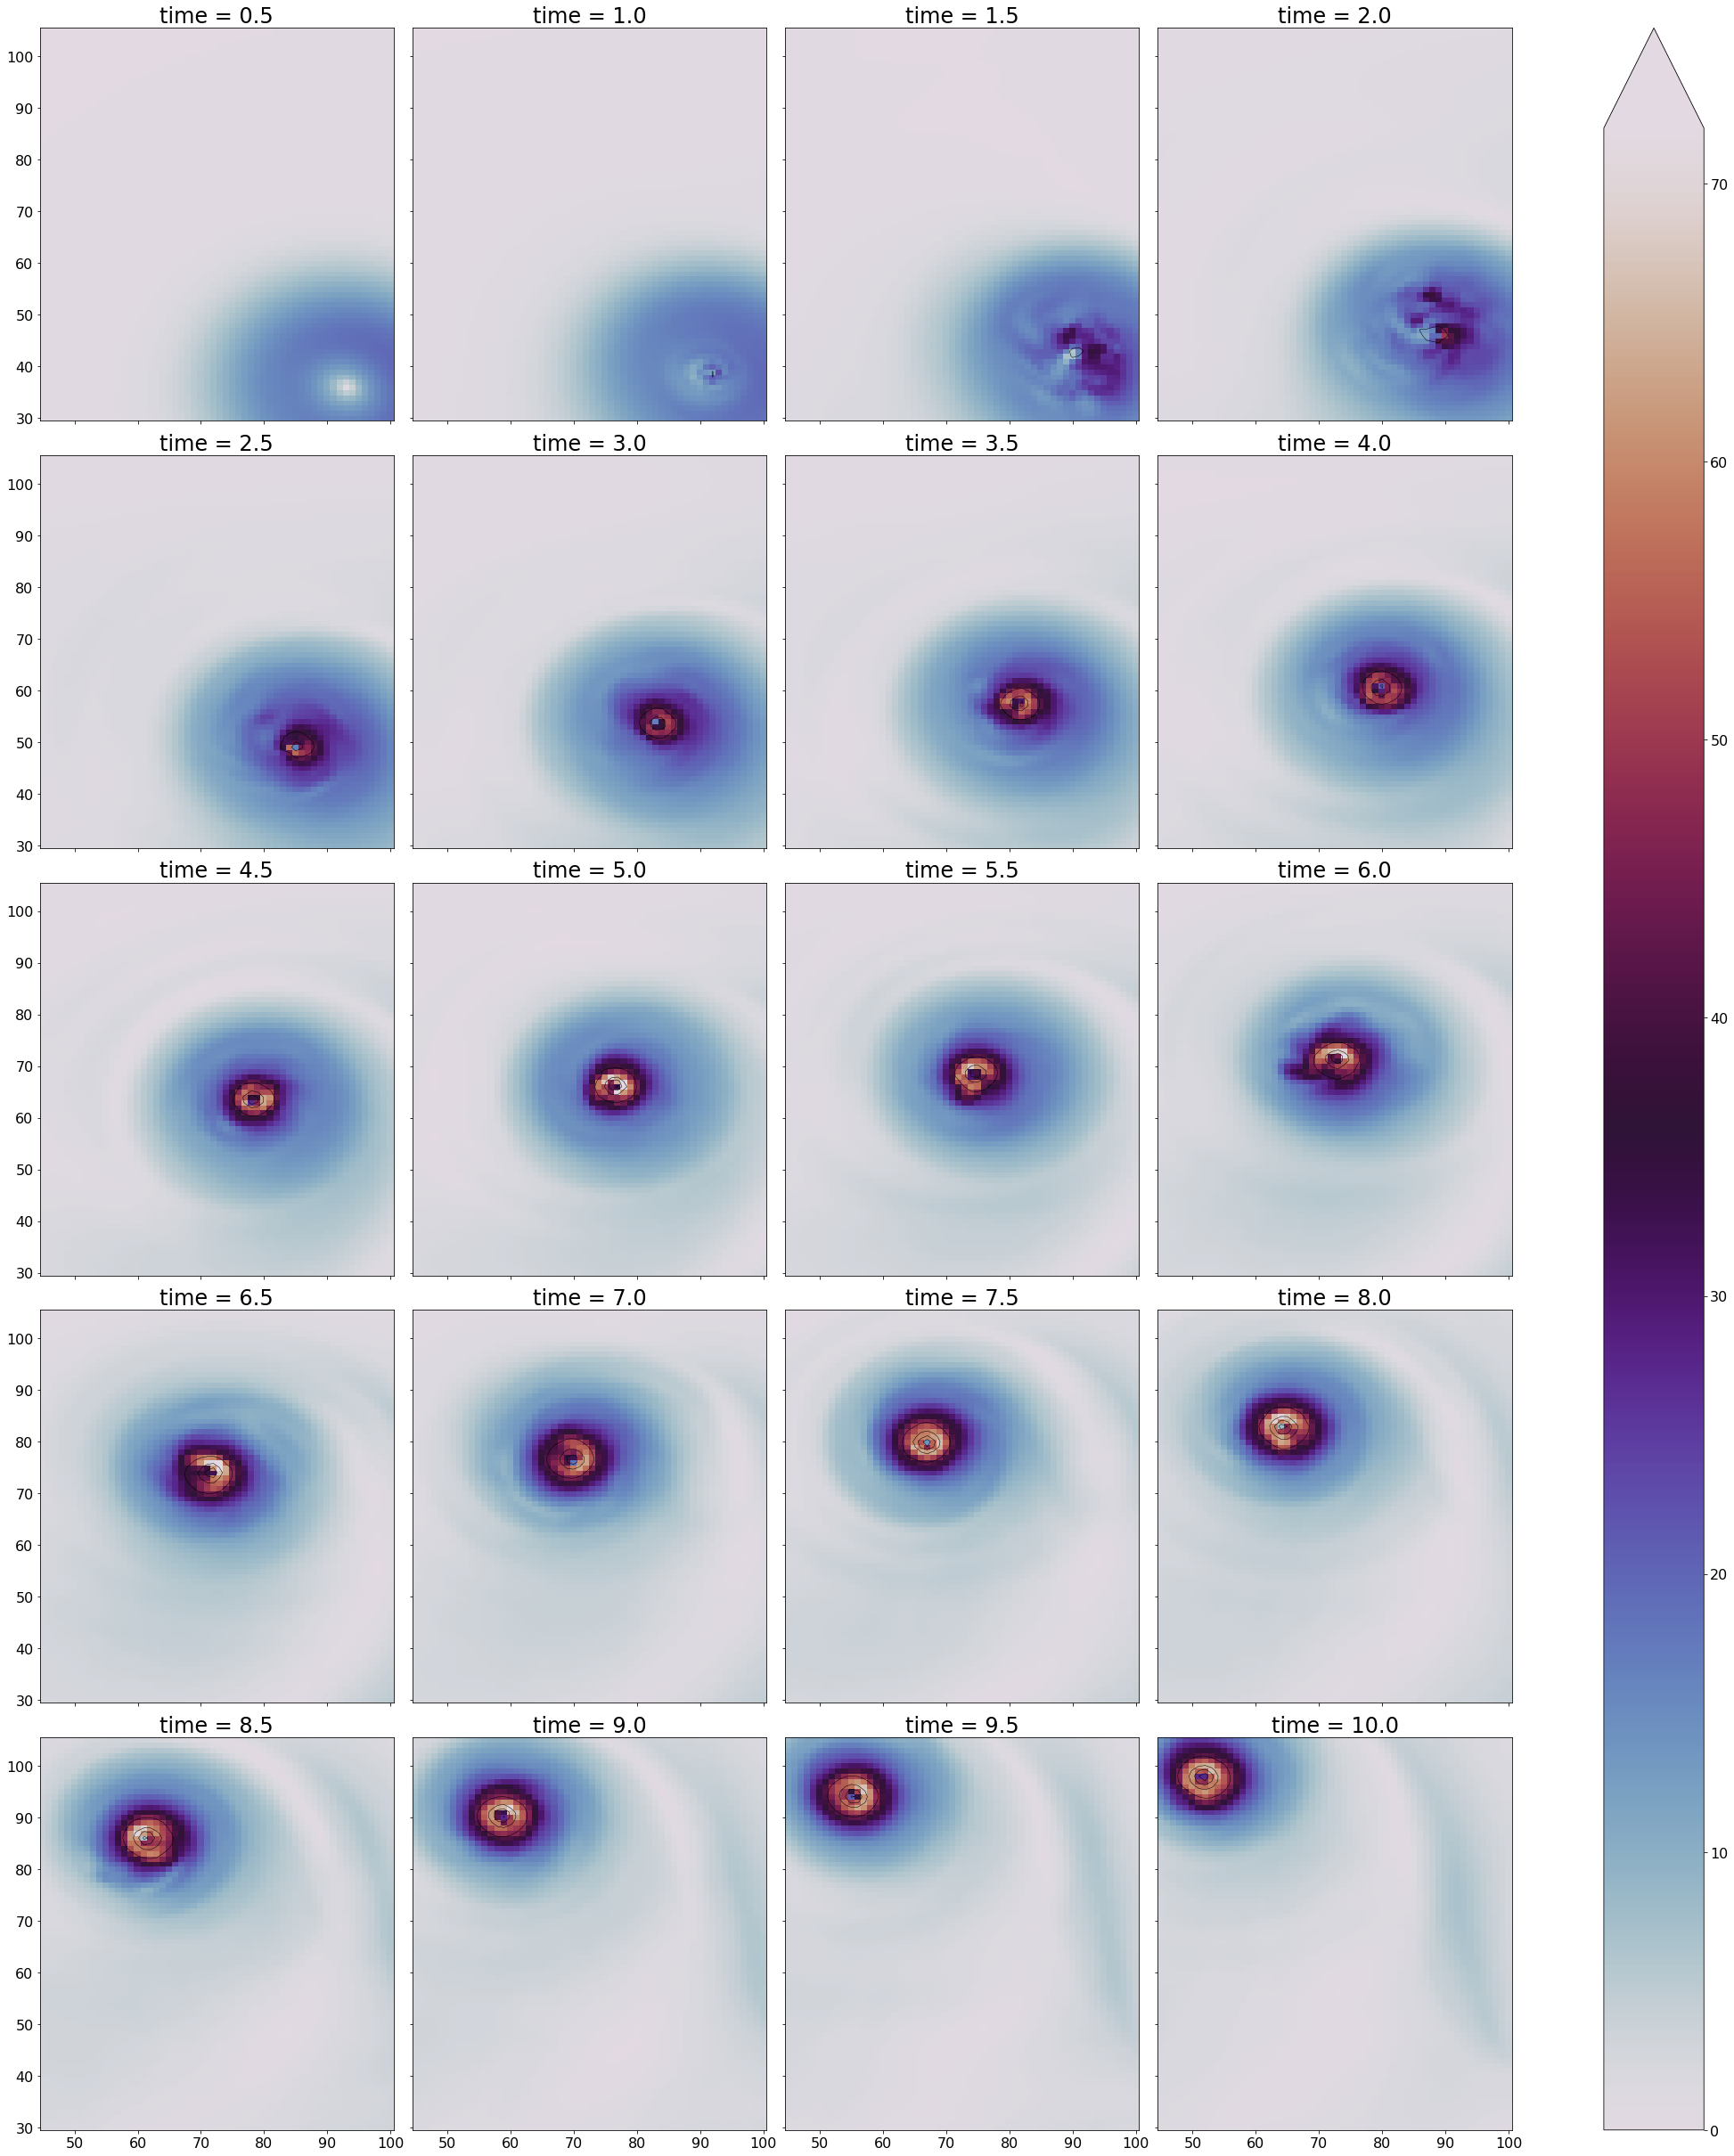

In [40]:
p=U850_ctl.sel(time=np.arange(0.5,10.5,0.5),grid_xt=slice(45,100),grid_yt=slice(30,105)).plot(col="time",col_wrap=4,vmin=0,vmax=72,figsize=(30,34),cmap=cm.twilight)


for ax, tt in zip(p.axes.flat,np.arange(0.5,10.5,0.5)):
    ds_ctl.PRESsfc.sel(time=tt,grid_xt=slice(45,100),grid_yt=slice(30,105)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
    ax.set_xlabel("")
    ax.set_ylabel("")

We can compare the vortex structure and location at 850 mb on day 10 from the four cases. There are some interesting facts seen here:

- Despite radically different amounts of diffusion to different components of the flow (rotational winds, divergent winds, passive tracers), all four cases do produce a distinct vortex with a calm center. This is most noticable in the "minimally-viscous" case, which otherwise produces the most diffuse vortex.
- The 4th-order damping case (using monotonic advection for everything) is weaker than the control but still produces a nicely-defined vortex. This is because FV3's dynamics again emphasizes rotational dynamics: there is no explicit diffusion to the rotational component of the flow, which is dominant at these resolutions.
- All four solutions have different locations. Since there is no mean wind, this means internal TC structure alone is causing differences in the beta drift of the vortex. (Note that while we see profound impacts on TC track by changing diffusion, this is likely because of the effect of diffusion on the synoptic-scale steering pattern, which is beyond the scope of this test.)


Text(0.5, 1.0, 'Monotonic tracer advection')

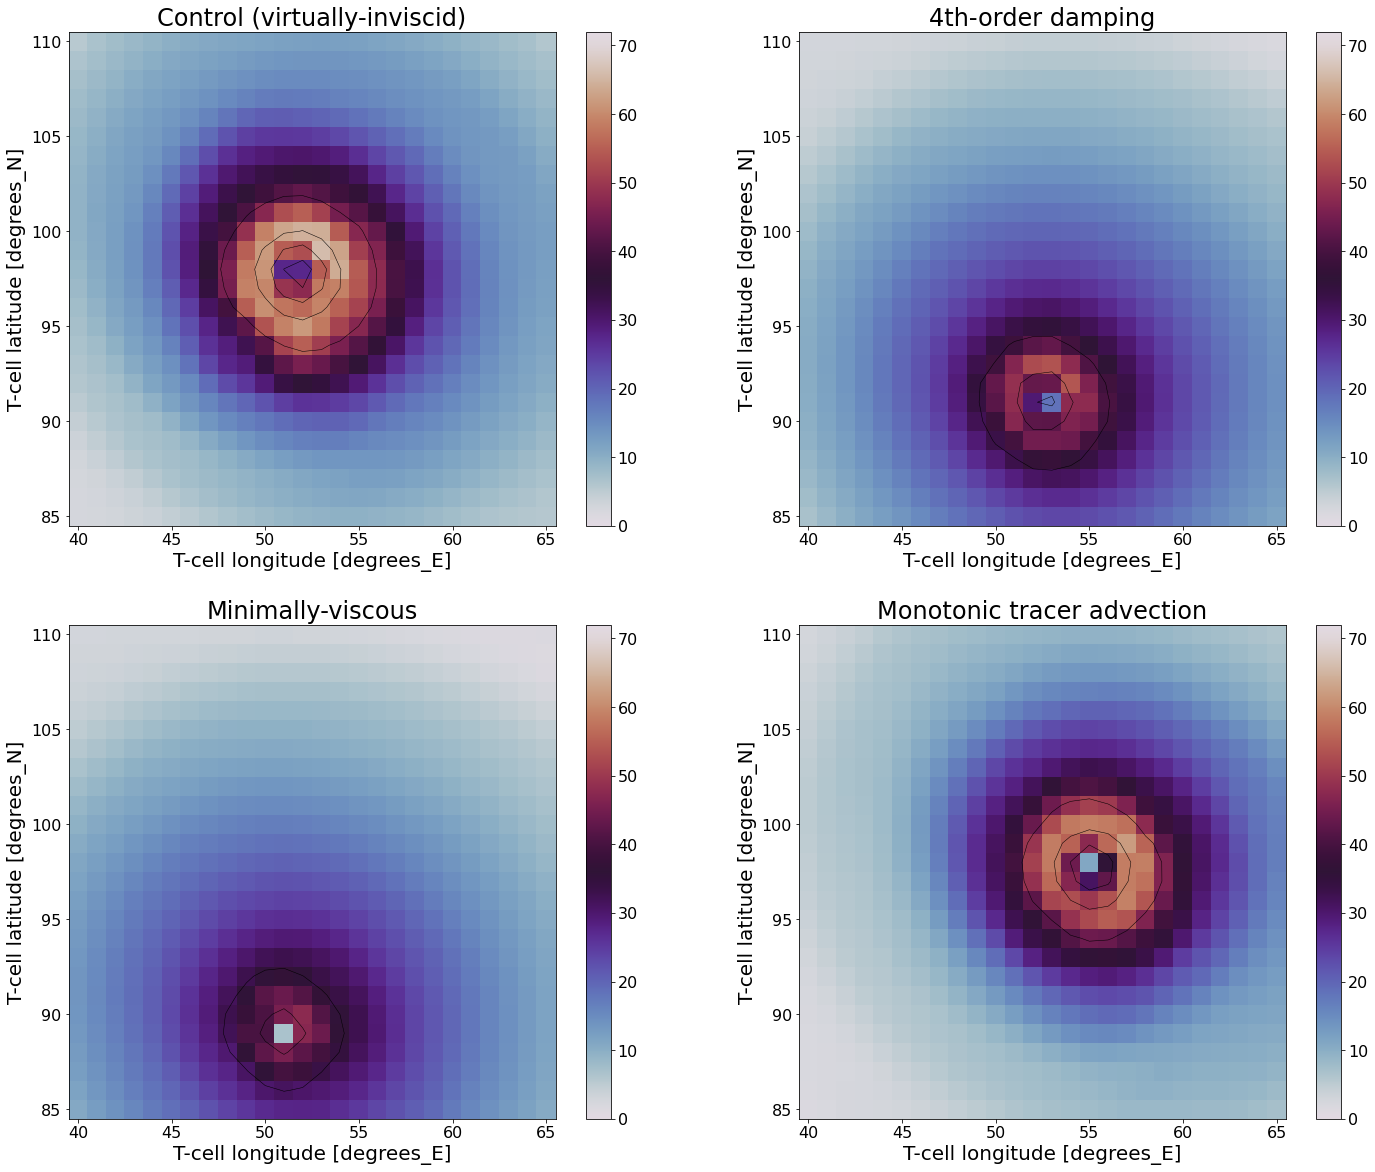

In [42]:
fig = plt.figure(figsize=(24,20))
ax = plt.subplot(2,2,1)
U850_ctl.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_ctl.PRESsfc.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Control (virtually-inviscid)")

ax = plt.subplot(2,2,2)
U850_d1.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_d1.PRESsfc.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("4th-order damping")

ax = plt.subplot(2,2,3)
U850_h6.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_h6.PRESsfc.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Minimally-viscous")

ax = plt.subplot(2,2,4)
U850_tr8.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_tr8.PRESsfc.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Monotonic tracer advection")


Column precipitable water can explain much of the intensification of the storms. In the control there is a strong gradient between moisture near the center and outside of the vortex, indicating the importance of water vapor for the intensification of the storm. The 4th-order damping and Minimally-viscous cases can get a lot of moisture into the center but the dynamics don't seem to be able to take advantage of it, perhaps due to diffusion of the vortex. (Since there is no convection scheme here that would fire in a real model, I wouldn't place a lot of emphasis on this result. Indeed in HiRAM intense vortices would form anyway due to its excellent convection scheme.) What is clear is that with the monotonic advection case, which has dynamics (and thus a dynamical vortex) identical to the control, the moisture is much more spread out and the gradient much weaker. The lesser amount of moisture reaching the center of the vortex limits intensification, yielding the finding of Gao et al. in 3-km T-SHiELD. 

Text(0.5, 1.0, 'Monotonic tracer advection')

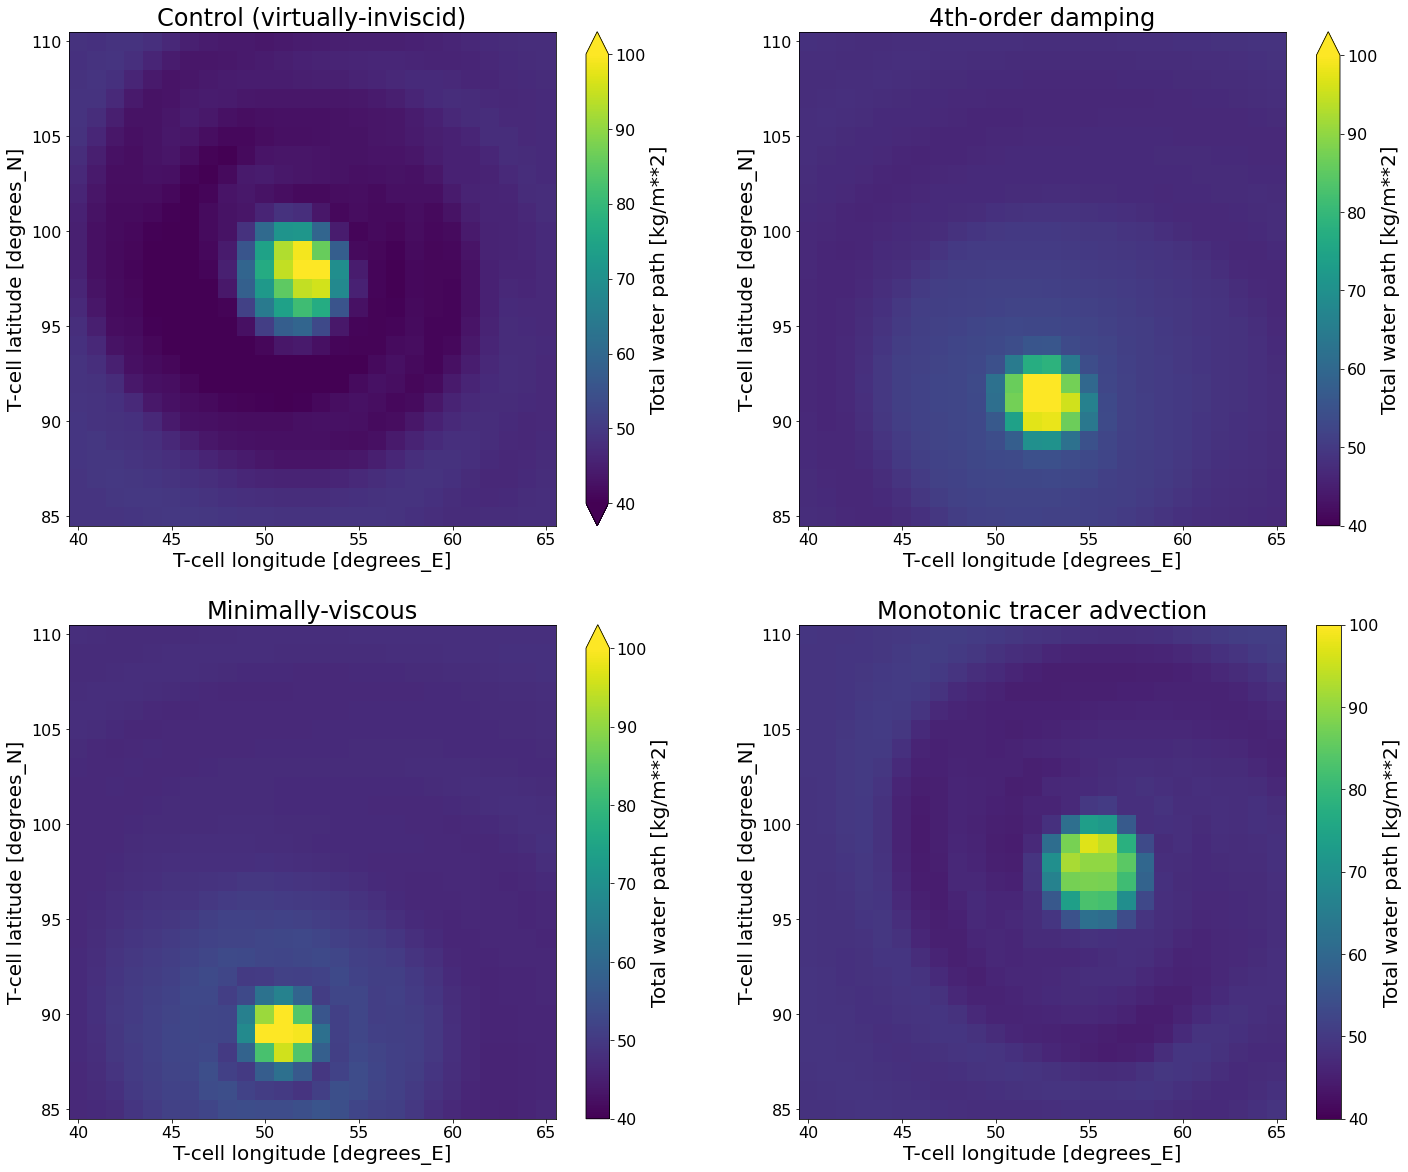

In [23]:
fig = plt.figure(figsize=(24,20))
ax = plt.subplot(2,2,1)
ds_ctl.PWAT.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Control (virtually-inviscid)")

ax = plt.subplot(2,2,2)
ds_d1.PWAT.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("4th-order damping")

ax = plt.subplot(2,2,3)
ds_h6.PWAT.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Minimally-viscous")

ax = plt.subplot(2,2,4)
ds_tr8.PWAT.sel(time=10,grid_xt=slice(40,65),grid_yt=slice(85,110)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Monotonic tracer advection")


At day 2, just before the control begins rapid intensification, it is very clear that it has much more moisture gathered into the center of the developing vortex, and is able to spin-up more quickly.

Text(0.5, 1.0, 'Monotonic tracer advection')

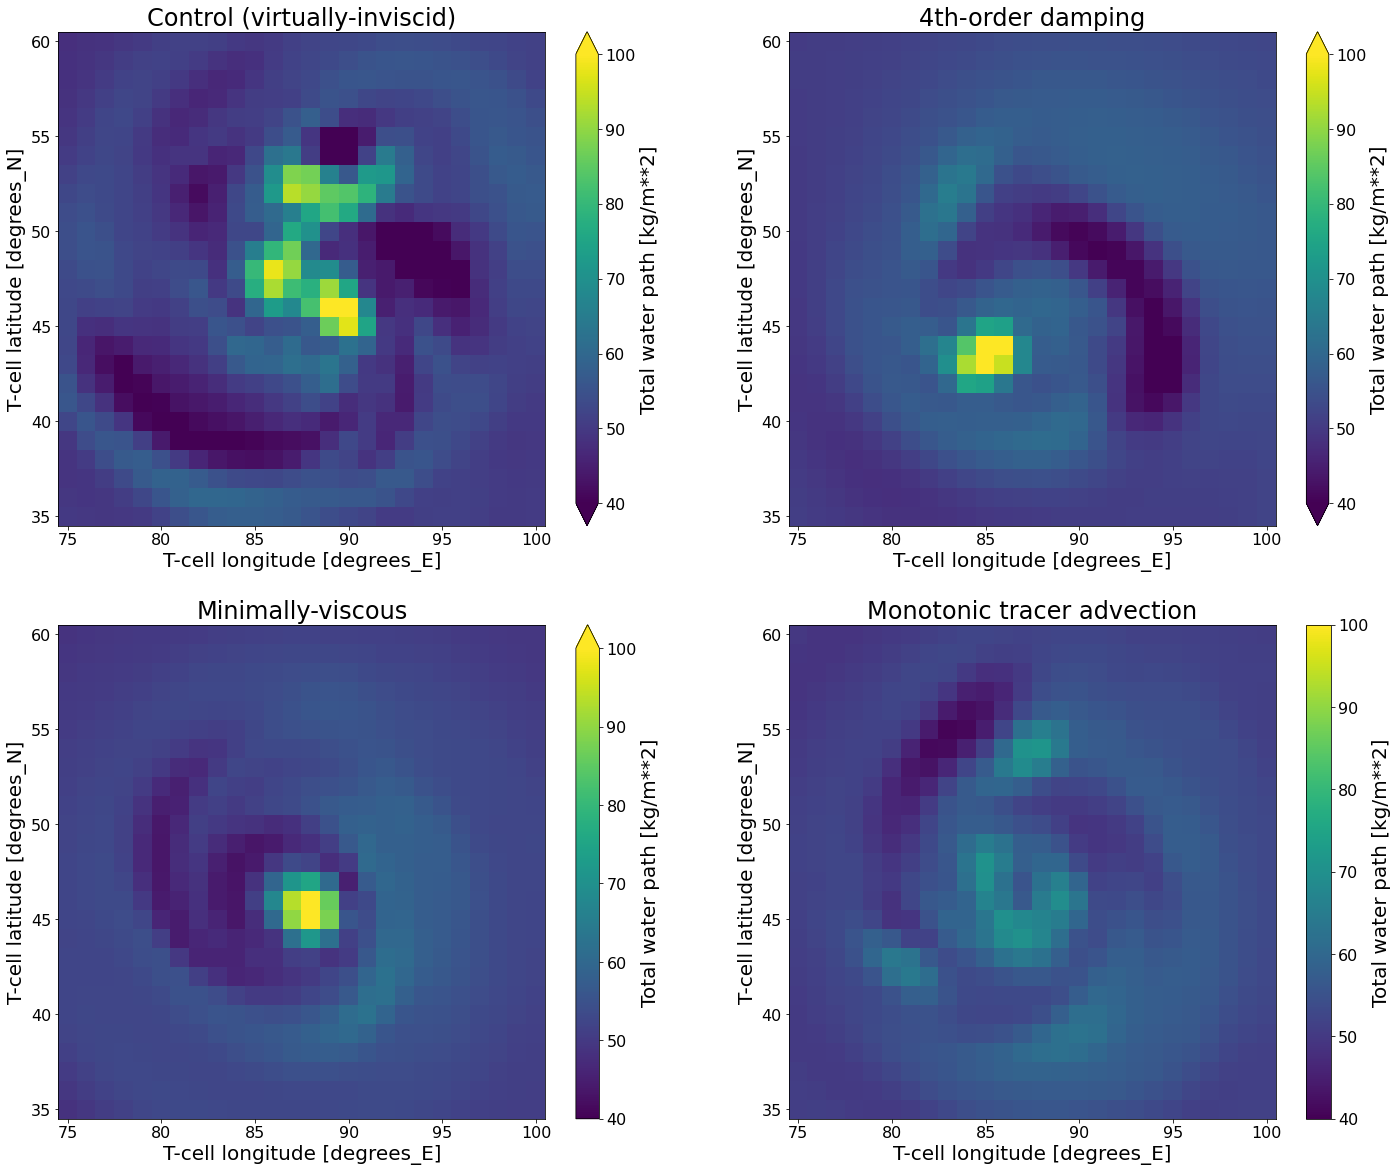

In [49]:
fig = plt.figure(figsize=(24,20))
ax = plt.subplot(2,2,1)
ds_ctl.PWAT.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Control (virtually-inviscid)")

ax = plt.subplot(2,2,2)
ds_d1.PWAT.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("4th-order damping")

ax = plt.subplot(2,2,3)
ds_h6.PWAT.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Minimally-viscous")

ax = plt.subplot(2,2,4)
ds_tr8.PWAT.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=40,vmax=100)
ax.set_title("Monotonic tracer advection")

Text(0.5, 1.0, 'Monotonic tracer advection')

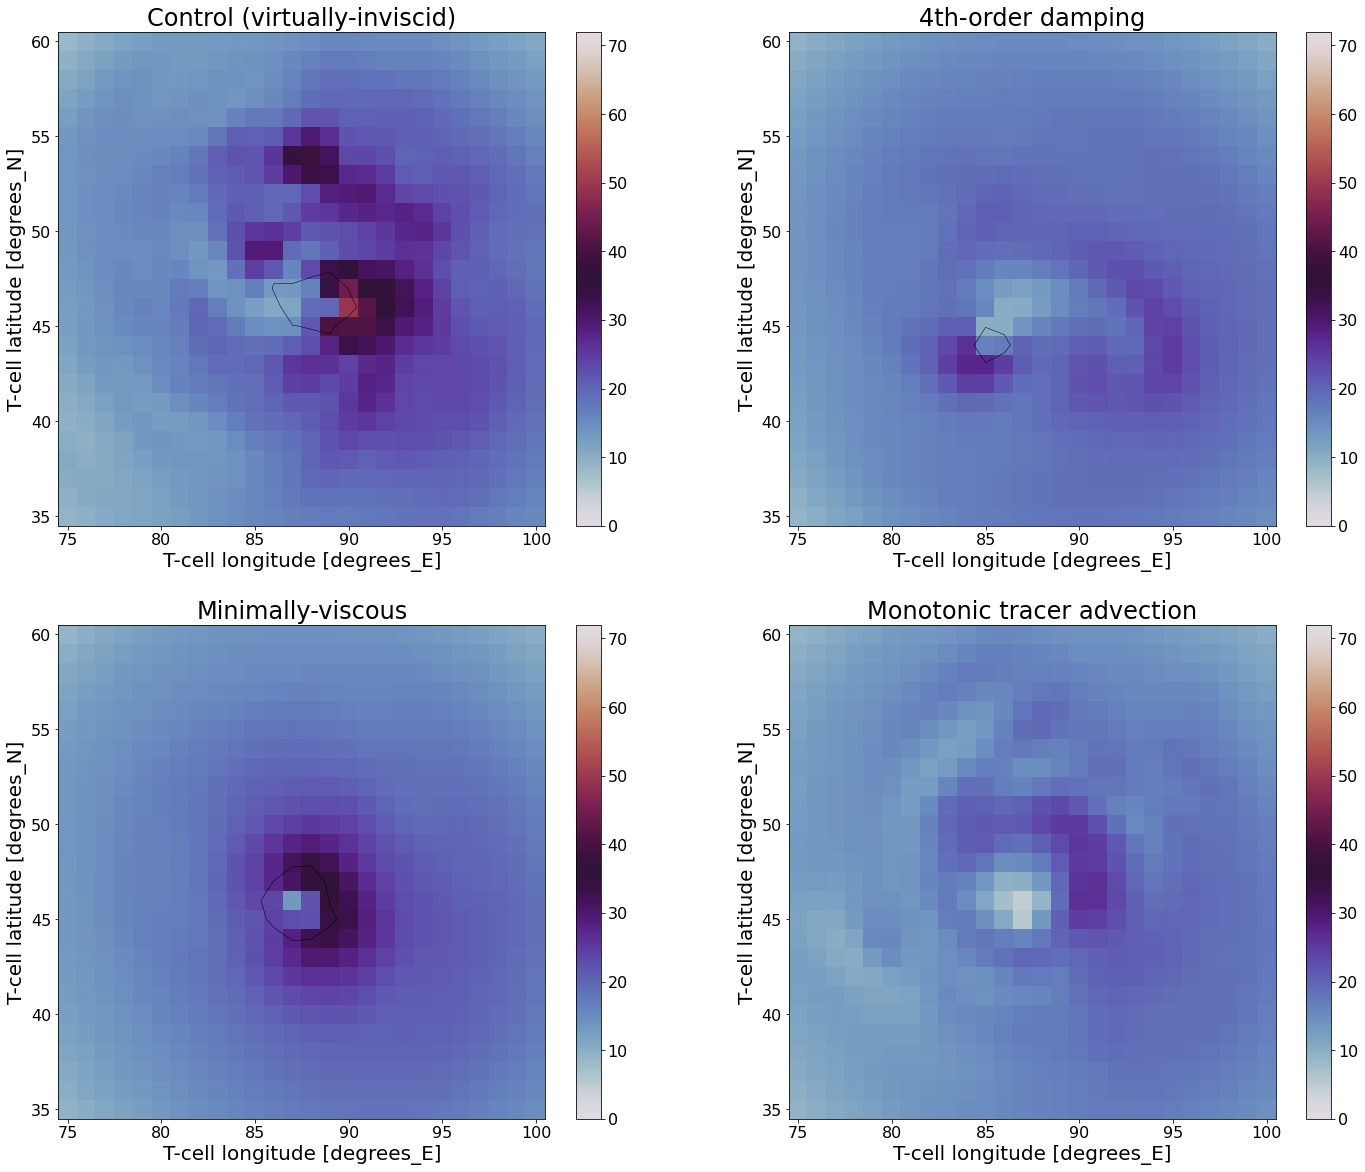

In [50]:
fig = plt.figure(figsize=(24,20))
ax = plt.subplot(2,2,1)
U850_ctl.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_ctl.PRESsfc.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Control (virtually-inviscid)")

ax = plt.subplot(2,2,2)
U850_d1.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_d1.PRESsfc.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("4th-order damping")

ax = plt.subplot(2,2,3)
U850_h6.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_h6.PRESsfc.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Minimally-viscous")

ax = plt.subplot(2,2,4)
U850_tr8.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot(ax=ax,vmin=0,vmax=72,cmap=cm.twilight)
ds_tr8.PRESsfc.sel(time=2,grid_xt=slice(75,100),grid_yt=slice(35,60)).plot.contour(levels=np.arange(90000,101000,2000),ax=ax,linewidths=0.5,colors='k')
ax.set_title("Monotonic tracer advection")